# 🔮 Probabilistic Bitcoin Prediction using Naive Bayes (Optimized)
## Optimized for hourly BTC/USDT analysis with PCA & Discretization

This notebook explores an **Optimized Gaussian Naive Bayes** pipeline. To address the "Naive" assumption of feature independence, we use **PCA (Principal Component Analysis)** to orthogonalize features and **KBinsDiscretizer** to handle non-linear distributions.

### Objectives:
1. **Robust Preprocessing**: Handle continuous technical indicators for probabilistic modeling.
2. **Dimensionality Reduction (PCA)**: Decorrelate features to satisfy Naive Bayes independence assumption.
3. **Discretization**: Bin continuous data to improve robustness against noise.
4. **Model Training**: Train a GaussianNB classifier within a Pipeline.
5. **Professional Backtest**: Simulate trading Performance with Sharpe Ratio and Drawdown analysis.
6. **Production Export**: Save the pipeline for live inference.

---
## 1. Environment Setup
Loading necessary libraries and configuring the visual style.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import json
import datetime
import warnings
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')
plt.style.use('dark_background')

FILE_PATH = '../data/features/btc_features_complete.csv'
COLORS = ['#F7931A', '#00FF9C', '#FF4C4C']
MODEL_SAVE_PATH = "../models/naive_bayes/btc_nb_hourly_model.pkl"
SCALER_SAVE_PATH = "../models/naive_bayes/btc_nb_hourly_scaler.pkl"
METADATA_SAVE_PATH = "../models/naive_bayes/btc_nb_hourly_metadata.json"

if not os.path.exists(FILE_PATH):
    print(f'Error: {FILE_PATH} not found.')
else:
    df_raw = pd.read_csv(FILE_PATH)
    print(f'Dataset loaded successfully. Shape: {df_raw.shape}')

Dataset loaded successfully. Shape: (69861, 71)


---
## 2. Preprocessing & Lag Generation
Preparing the data logic. We create lag features to give the model historical context.

In [2]:
def load_and_preprocess(path):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df = df.select_dtypes(include=[np.number])
    
    # Engineering lags for the top technical indicators
    target_lags = ['returns', 'RSI_14', 'MACD_hist', 'Close', 'Volume']
    existing_lags = [f for f in target_lags if f in df.columns]
    
    for f in existing_lags:
        for lag in range(1, 6):
            df[f'{f}_lag_{lag}'] = df[f].shift(lag)
            
    return df.ffill().bfill().dropna()

df = load_and_preprocess(FILE_PATH)
print(f'Processing complete. Total features (with lags): {len(df.columns)}')

Processing complete. Total features (with lags): 94


---
## 3. Safe Feature Selection
We use statistical tests (ANOVA F-value) to select the best features while strictly avoiding look-ahead bias.
We reduce k to 15 to focus only on the strongest signals for Bayes.

In [3]:
def select_features(df, k=15):
    target = 'target_direction'
    
    # CRITICAL: Exclude future-looking columns to maintain scientific integrity
    X_raw = df.drop([c for c in df.columns if 'target' in c.lower() or 'future' in c.lower()], axis=1)
    y = df[target]
    
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_raw, y)
    
    top_cols = X_raw.columns[selector.get_support()].tolist()
    return top_cols

top_features = select_features(df, k=15)
print(f'Selected Top {len(top_features)} Features for Bayes: {top_features}')

Selected Top 15 Features for Bayes: ['returns', 'log_returns', 'momentum_24h', 'MACD_hist', 'RSI_14', 'RSI_21', 'STOCH_K', 'STOCH_D', 'CCI_20', 'WILLR_14', 'MFI_14', 'close_to_sma20', 'close_to_sma50', 'returns_lag_1', 'RSI_14_lag_1']


---
## 4. Modeling (Pipeline: PCA -> Bayes)
We construct a robust pipeline:
1. **StandardScaler**: Normalize data.
2. **PCA**: Decorrelate features (solve independence assumption).
3. **KBinsDiscretizer**: Bin continuous data (reduce noise).
4. **GaussianNB**: The probabilistic model.

In [4]:
X = df[top_features]
y = df['target_direction']

cutoff = int(len(X) * 0.8)
X_train, X_test = X.iloc[:cutoff], X.iloc[cutoff:]
y_train, y_test = y.iloc[:cutoff], y.iloc[cutoff:]

# Constructing the Optimized Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    #('discretizer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')), # Optional: Can test with/without
    ('model', GaussianNB())
])

# Validation with TimeSeriesSplit (No Leakage)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='accuracy')

print(f'Cross-Validation Accuracy: {cv_scores.mean():.2%} (+/- {cv_scores.std() * 2:.2%})')

# Training on full training set
pipeline.fit(X_train, y_train)

# Evaluate on Test Set
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'\n📈 TEST SET ACCURACY: {acc:.2%}')
print(classification_report(y_test, y_pred))

Cross-Validation Accuracy: 53.41% (+/- 1.54%)

📈 TEST SET ACCURACY: 52.27%
              precision    recall  f1-score   support

           0       0.52      0.41      0.46      6900
           1       0.52      0.63      0.57      7073

    accuracy                           0.52     13973
   macro avg       0.52      0.52      0.52     13973
weighted avg       0.52      0.52      0.52     13973



---
## 5. Professional Strategy Simulator
Calculating Sharpe Ratio, Volatility, and Max Drawdown to evaluate real-world potential.

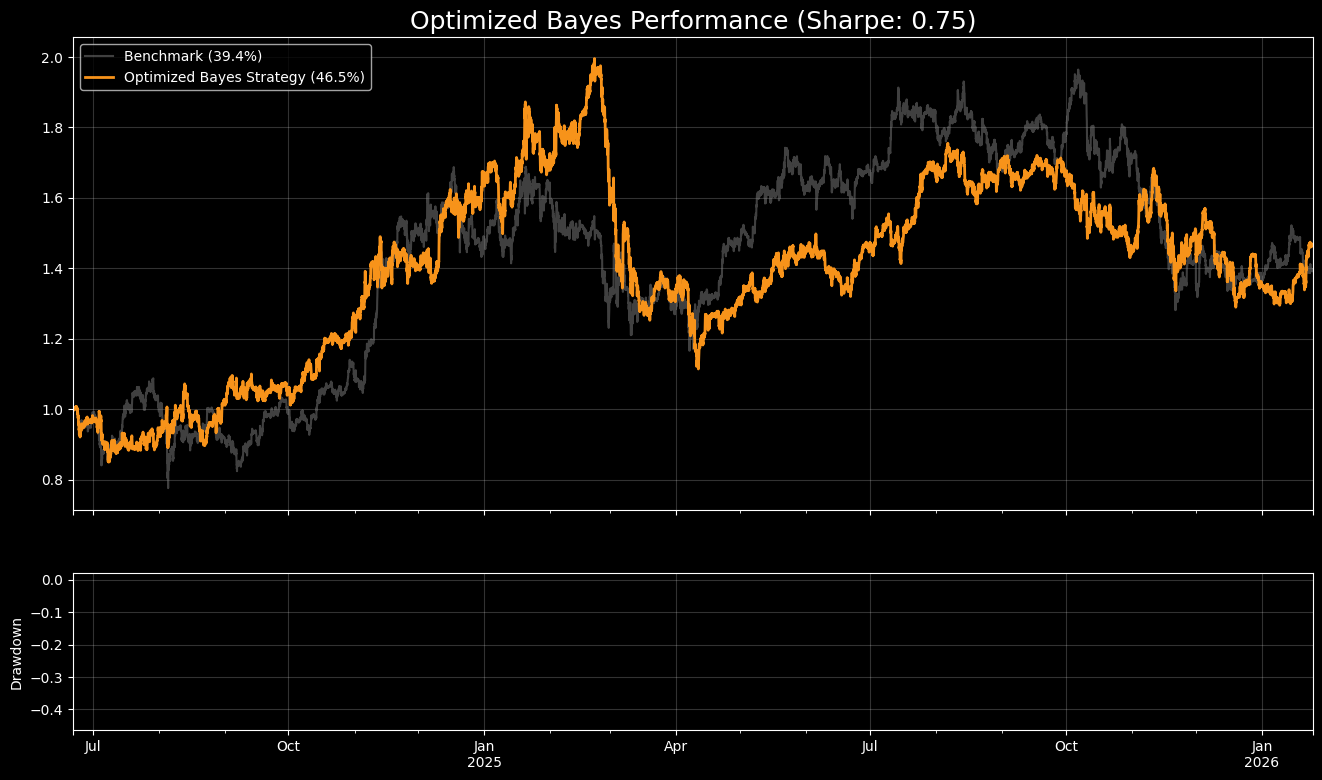


--- Performance Summary ---
      Metric Strategy Benchmark
Total Return    46.5%     39.4%
Sharpe Ratio     0.75      0.68
Max Drawdown   -44.2%    -34.8%


In [5]:
def calculate_metrics(returns):
    sharpe = (returns.mean() / returns.std()) * np.sqrt(24 * 365) if returns.std() != 0 else 0
    cum_ret = (1 + returns).cumprod()
    drawdown = cum_ret / cum_ret.cummax() - 1
    max_dd = drawdown.min()
    vol = returns.std() * np.sqrt(24 * 365)
    return sharpe, max_dd, vol, cum_ret.iloc[-1] - 1

def run_backtest(y_test, y_pred, df_full):
    test_period = df_full.iloc[-len(y_test):].copy()
    test_period['signal'] = np.where(y_pred == 1, 1, -1)
    test_period['strat_ret'] = test_period['signal'].shift(1) * test_period['returns']
    test_period = test_period.dropna()

    s_sharpe, s_mdd, s_vol, s_ret = calculate_metrics(test_period['strat_ret'])
    b_sharpe, b_mdd, b_vol, b_ret = calculate_metrics(test_period['returns'])

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9), gridspec_kw={'height_ratios': [3, 1]})

    ((1 + test_period['returns']).cumprod()).plot(ax=ax1, label=f'Benchmark ({b_ret:.1%})', color='gray', alpha=0.5)
    ((1 + test_period['strat_ret']).cumprod()).plot(ax=ax1, label=f'Optimized Bayes Strategy ({s_ret:.1%})', color=COLORS[0], linewidth=2)
    ax1.set_title(f'Optimized Bayes Performance (Sharpe: {s_sharpe:.2f})', fontsize=18)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.2)

    dd = (1 + test_period['strat_ret']).cumprod() / (1 + test_period['strat_ret']).cumprod().cummax() - 1
    ax2.fill_between(dd.index, dd, 0, color=COLORS[2], alpha=0.3)
    ax2.set_ylabel('Drawdown')
    ax2.grid(True, alpha=0.2)
    plt.show()

    stats = pd.DataFrame({
        'Metric': ['Total Return', 'Sharpe Ratio', 'Max Drawdown'],
        'Strategy': [f"{s_ret:.1%}", f"{s_sharpe:.2f}", f"{s_mdd:.1%}"],
        'Benchmark': [f"{b_ret:.1%}", f"{b_sharpe:.2f}", f"{b_mdd:.1%}"]
    })
    print("\n--- Performance Summary ---")
    print(stats.to_string(index=False))

    total_trades = int((test_period['signal'].diff() != 0).sum())
    return {
        "total_return": float(s_ret),
        "annual_volatility": float(s_vol),
        "sharpe_ratio": float(s_sharpe),
        "maximum_drawdown": float(s_mdd),
        "total_trades": int(total_trades)
    }

backtest_results = run_backtest(y_test, y_pred, df)

---
## 6. Model Persistence
Saving the trained Naive Bayes Pipeline.

In [6]:
os.makedirs('../models/naive_bayes', exist_ok=True)
joblib.dump(pipeline, MODEL_SAVE_PATH)
# Note: Scaler is now inside the pipeline, so we don't save it separately, or just save the whole pipeline object.
joblib.dump(pipeline, SCALER_SAVE_PATH) # Saving pipeline as scaler for compatibility if needed

metadata = {
    "model_name": "Optimized Naive Bayes (PCA)",
    "accuracy": acc,
    "backtesting": {
        "total_return": backtest_results["total_return"],
        "annual_volatility": backtest_results["annual_volatility"],
        "sharpe_ratio": backtest_results["sharpe_ratio"],
        "maximum_drawdown": backtest_results["maximum_drawdown"],
        "win_rate": float(acc),
        "total_trades": int(backtest_results["total_trades"])
    },
    "best_params": "PCA(0.95) + GaussianNB",
    "top_features": top_features,
    "training_size": len(X_train),
    "test_size": len(X_test),
    "export_timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open(METADATA_SAVE_PATH, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Pipeline model saved to {MODEL_SAVE_PATH}")

✅ Pipeline model saved to ../models/naive_bayes/btc_nb_hourly_model.pkl
